In [2]:
import os
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
#import pooch
import scanpy as sc
import scvi
import torch

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/flax/struct.py:132: FutureWarni

In [3]:
scvi.settings.seed = 1234
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Global seed set to 1234


Last run with scvi-tools version: 1.0.4


In [16]:
sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/peakVI/MM168"

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}
%config InlineBackend.figure_format="retina"

In [6]:
path_to_10x = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/processed/23Oct23/cellranger/MM168/outs/filtered_peak_bc_matrix"

In [7]:
adata = scvi.data.read_10x_atac(path_to_10x)

In [9]:
print("# regions before filtering:", adata.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)

print("# regions after filtering:", adata.shape[-1])

# regions before filtering: 192667
# regions after filtering: 22051


In [10]:
scvi.model.PEAKVI.setup_anndata(adata)

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
model = scvi.model.PEAKVI(adata)

In [13]:
# Check the set-up
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 7998  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 22051 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [15]:
model.train()

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
LOCAL_RANK: 0 - CU

Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 97/500:  19%|█▉        | 97/500 [01:47<07:27,  1.11s/it, v_num=1, train_loss_step=5.73e+6, train_loss_epoch=9.97e+7]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 6429.100. Signaling Trainer to stop.


In [17]:
model_dir = os.path.join(save_dir, "model")
model.save(model_dir, overwrite=True)

In [18]:
PEAKVI_LATENT_KEY = "X_peakvi"

latent = model.get_latent_representation()
adata.obsm[PEAKVI_LATENT_KEY] = latent
latent.shape

(7998, 12)

In [19]:
PEAKVI_CLUSTERS_KEY = "clusters_peakvi"

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep=PEAKVI_LATENT_KEY)
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added=PEAKVI_CLUSTERS_KEY, resolution=0.2)

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


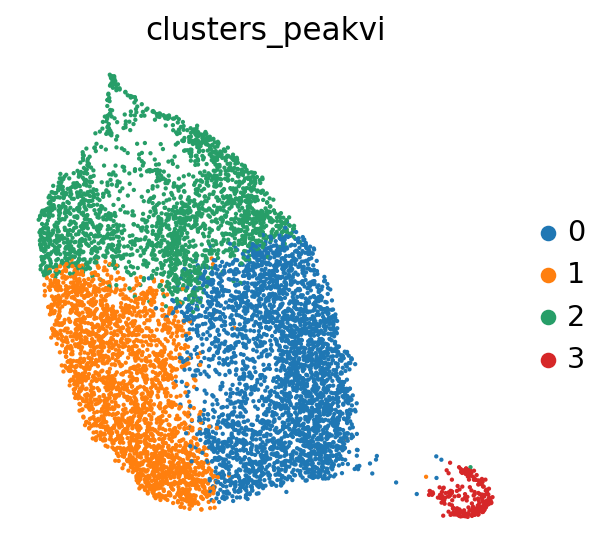

In [20]:
sc.pl.umap(adata, color=PEAKVI_CLUSTERS_KEY)

In [21]:
adata.write(os.path.join(save_dir, "clustered.h5ad"))

# Differential accessibility

In [22]:
# Using a known factor to compare a cluster against all other clusters
da_res0 = model.differential_accessibility(
    groupby=PEAKVI_CLUSTERS_KEY, group1="0", two_sided=False
)
da_res1 = model.differential_accessibility(
    groupby=PEAKVI_CLUSTERS_KEY, group1="1", two_sided=False
)
da_res2 = model.differential_accessibility(
    groupby=PEAKVI_CLUSTERS_KEY, group1="2", two_sided=False
)
da_res3 = model.differential_accessibility(
    groupby=PEAKVI_CLUSTERS_KEY, group1="3", two_sided=False
)
da_res0.head()

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr4:70563751-70564657,0.9034,False,2.235587,-0.311294,-0.024986,0.726332,0.415039,0.120722,0.095736
chr4:132909981-132910892,0.8964,False,2.157849,-0.339213,-0.049392,0.557854,0.218640,0.100187,0.050794
chr18:66523245-66524152,0.8948,False,2.140737,-0.223096,-0.000878,0.655850,0.432754,0.102676,0.101798
chr7:13838841-13839744,0.8930,False,2.121758,-0.278285,-0.013890,0.544227,0.265941,0.082452,0.068562
chr8:88367262-88368167,0.8912,False,2.103057,-0.292432,-0.013070,0.666110,0.373678,0.107343,0.094273


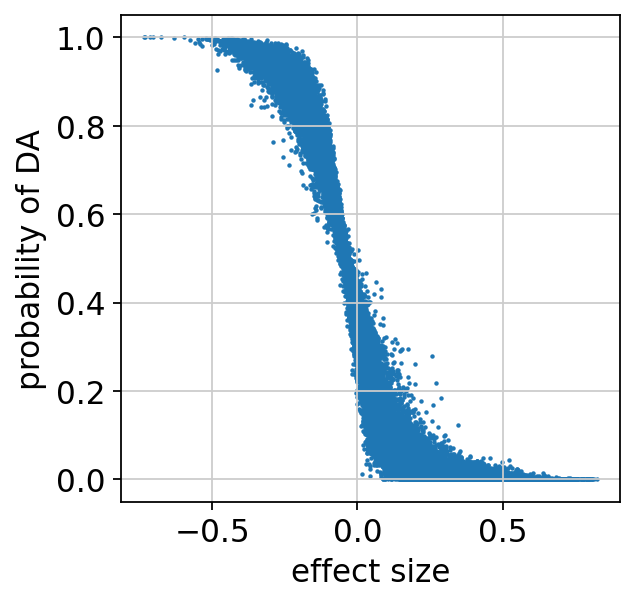

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr5:49601420-49602141,1.0000,True,18.420681,-0.731964,-0.407503,0.966947,0.234983,0.458874,0.051371
chr5:49659439-49660343,1.0000,True,18.420681,-0.736520,-0.418817,0.970674,0.234153,0.471861,0.053045
chr5:49658041-49658982,0.9998,True,8.516943,-0.678329,-0.401870,0.969056,0.290727,0.467532,0.065662
chr16:46390064-46390839,0.9998,True,8.516943,-0.703125,-0.393309,0.970182,0.267057,0.450216,0.056907
chr5:49661058-49661893,0.9998,True,8.516943,-0.715458,-0.377152,0.966826,0.251369,0.432900,0.055749
chr13:18211621-18212531,0.9996,True,7.823621,-0.596845,-0.307935,0.969645,0.372800,0.393939,0.086005
chr6:118800254-118801153,0.9992,True,7.130086,-0.491252,0.033926,0.722529,0.231276,0.017316,0.051242
chr3:75668804-75669717,0.9990,True,6.906745,-0.631140,-0.171692,0.945842,0.314702,0.246753,0.075061
chr18:56910798-56911684,0.9984,True,6.436144,-0.521658,0.035617,0.826600,0.304941,0.030303,0.065920
chr3:93470146-93471057,0.9984,True,6.436144,-0.435312,-0.398021,0.985362,0.550050,0.523810,0.125789


In [26]:
plt.scatter(da_res3.effect_size, da_res3.prob_da, s=1)
plt.xlabel("effect size")
plt.ylabel("probability of DA")
plt.show()

da_res3.loc[da_res3.is_da_fdr].sort_values("prob_da", ascending=False).head(10)

# DONE!

---